Model selection is the task of selecting a statistical model from a set of candidate models, given data. In the simplest cases, a pre-existing set of data is considered. Given candidate models of similar predictive or explanatory power, the simplest model is most likely to be the best choice.

The data is available in Google BigQuery that can be downloaded from here. The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv.

In [11]:
import logging
import pandas as pd
pd.set_option('max_colwidth', 800)
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

%matplotlib inline

In [12]:
df = pd.read_json('./data/dfExoplanetsNASAdetected100rand_v2.json', orient = 'table')
df = df[['sent', 'label']]
df.columns=["post","tags"]

In [13]:
df.head(10)

,post,tags
0,"We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",discovery
1,"Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new candidate transitional, evolved, evolved transitional, and debris disks.",discovery
2,"Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.",None
3,"We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star with as few as 10 transits, assuming photon-limited noise.",discovery
4,We present two exoplanets detected at Keck Observatory.,discovery
5,"This disfavours the possibility of GI-caused spiral structure in systems with q&lt;0.25 being detected in relatively short integration times, such as those found in the DSHARP ALMA survey (Andrews et al. 2018; Huang et al. 2018).",None
6,"Planets lying in this zone are then more easily detected with the radial-velocity method [3], the most successful in detecting exoplanets.",None
7,"The 2004 flux density was 0.05 Jy, about an order of magnitude lower than the single 2003 burst and the five bursts detected in 2002.",discovery
8,"This statement is supported by a figure given in the article, which shows a primary signal with a depth of 6 mmag, detected with 4σ confidence and a possible secondary signal with a depth of 2 mmag.",
9,"Combining these instruments with powerful telescopes, astronomers have detected thousands of exoplanets.",None


df['post'].apply(lambda x: len(x.split(' '))).sum()

We have over 2617 words in the data.

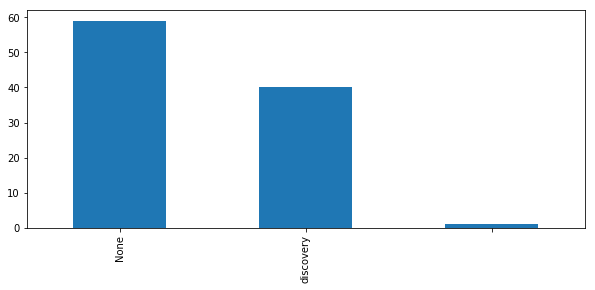

In [14]:
my_tags = ['None','discovery']
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

The classes are very well balanced.

In [15]:
df.head(1)

,post,tags
0,"We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",discovery


In [16]:
df['post'].apply(lambda x: len(x.split(' '))).sum()

2617

Now we have 1581 words to work with.

In [17]:
X = df.post
y = df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [18]:
X.head(5)

0                                                                                                                                                                                                                 We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.
1    Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new candidate transitional, evolved, evolved transitional, and debris disks.
2                                                                                                                                                                                                                      Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0

In [19]:
y.head(5)

0    discovery
1    discovery
2         None
3    discovery
4    discovery
Name: tags, dtype: object

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.5333333333333333
              precision    recall  f1-score   support

        None       0.53      1.00      0.70        16
   discovery       0.00      0.00      0.00        14

    accuracy                           0.53        30
   macro avg       0.27      0.50      0.35        30
weighted avg       0.28      0.53      0.37        30

Wall time: 17 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
y_pred = nb.fit(X_train, y_train).predict(X_test)

In [23]:
# The ConfusionMatrix visualizer taxes a model
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[16,  0],
       [14,  0]], dtype=int64)